# IRMDP: Homework 6.2 and 6.3

Implementation is according to [testSensitivity.py](https://github.com/sschlenkrich/QuantLibPython/blob/master/testSensitivity.py).

## Importing of classes and necessary setting as in testSensitivity.py

In [1]:
import sys, os, io, copy, time
if locals().get('__file__'):
    sys.path.append(os.path.join(os.path.dirname(__file__),'QuantLibWrapper'))
else:
    sys.path.append(os.path.join(os.getcwd(),'QuantLibWrapper'))
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from itertools import product

import QuantLib as ql

from QuantLibWrapper import YieldCurve, Swap, Swaption, createSwaption, \
    HullWhiteModel, HullWhiteModelFromSwaption, BermudanSwaption, PDESolver, \
    DensityIntegrationWithBreakEven, CubicSplineExactIntegration, \
    SimpsonIntegration, HermiteIntegration
from QuantLibWrapper.YieldCurve import YieldCurve

In [2]:
terms = [    '1y',    '2y',    '3y',    '4y',    '5y',    '6y',    '7y',    '8y',    '9y',   '10y',   '12y',   '15y',   '20y',   '25y',   '30y' ] 
rates = [ 2.70e-2, 2.75e-2, 2.80e-2, 3.00e-2, 3.36e-2, 3.68e-2, 3.97e-2, 4.24e-2, 4.50e-2, 4.75e-2, 4.75e-2, 4.70e-2, 4.50e-2, 4.30e-2, 4.30e-2 ] 

if False:
    terms = [ '30y'   ]  # flat curve
    rates = [ 5.00e-2 ] 
rates2 = [ r+0.005 for r in rates ]

discCurve = YieldCurve(terms,rates)
projCurve = YieldCurve(terms,rates)

a = 0.03 # mean reversion
vol = 0.01
h = 1.0e-12

swaptionStrike = createSwaption('10y','10y',discCurve,projCurve).fairRate() \
                 + vol * np.sqrt(10.0) * np.sqrt(3.0)
swaptionStrike = 0.1048
print('swaptionStrike = ' + str(swaptionStrike))

swaptionStrike = 0.1048


## Computation

In [3]:
def compute_integration(method,n_grid_points=101,lambda_std_devs=5,hs=[10.0**(-k) for k in range(3,18)]):
    res = []
    assert method in [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration], 'the method is not allowed'
    if isinstance(n_grid_points,int): n_grid_points = [n_grid_points]
    if isinstance(lambda_std_devs,int): lambda_std_devs = [lambda_std_devs]
    args = pd.DataFrame(list(product(n_grid_points,lambda_std_devs,hs)), columns=['n_grid_points','lambda_std_devs','h'])
    for _,arg in args.iterrows():
        h = arg['h']
        n = arg['n_grid_points']
        l = arg['lambda_std_devs']
        print('h = ' + str(h))
        # swaptions
        s0 = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol)
        sp = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol+h)
        sm = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol-h)
        # models
        h0 = HullWhiteModelFromSwaption(s0,a)
        hp = HullWhiteModelFromSwaption(sp,a)
        hm = HullWhiteModelFromSwaption(sm,a)
        if False:
            # Berms via PDE
            p0 = BermudanSwaption([s0],a,model=h0,method=PDESolver(h0,n,3.0,0.5,1.0/12.0))
            pp = BermudanSwaption([sp],a,model=hp,method=PDESolver(hp,n,3.0,0.5,1.0/12.0))
            pm = BermudanSwaption([sm],a,model=hm,method=PDESolver(hm,n,3.0,0.5,1.0/12.0))
        # Berms via density integration
        i10 = BermudanSwaption([s0],a,model=h0,method=method(h0,n,l))
        i1p = BermudanSwaption([sp],a,model=hp,method=method(hp,n,l))
        i1m = BermudanSwaption([sm],a,model=hm,method=method(hm,n,l))
        
        i20 = BermudanSwaption([s0],a,model=h0,method=DensityIntegrationWithBreakEven(method(h0,n,l)))
        i2p = BermudanSwaption([sp],a,model=hp,method=DensityIntegrationWithBreakEven(method(hp,n,l)))
        i2m = BermudanSwaption([sm],a,model=hm,method=DensityIntegrationWithBreakEven(method(hm,n,l)))

        res.append([ h, n,l,s0.vega(),
            s0.npv(),            sp.npv(),            sm.npv(),
            s0.npvHullWhite(h0), sp.npvHullWhite(hp), sm.npvHullWhite(hm),
            #p0.npv(),            pp.npv(),            pm.npv(),
            i10.npv(),            i1p.npv(),            i1m.npv(),
            i20.npv(),            i2p.npv(),            i2m.npv()
        ])
    column = [ 'h', 'n_grid_points', 'lambda_std_devs', 'Vega', 'B0', 'Bp', 'Bm', 'H0', 'Hp', 'Hm','I0','Ip','Im','I_be_0', 'I_be_p', 'I_be_m']
    return pd.DataFrame(dict(zip(column,np.array(res).T)))


In [161]:
def compute_integration2(method,n_grid_points=101,lambda_std_devs=5,hs=[10.0**(-k) for k in range(3,18)],break_even=True,degree=None):
    res = []
    assert method in [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration], 'the method is not allowed'
    if method == HermiteIntegration:
        assert isinstance(degree,int), 'degree must be integer'
    if isinstance(n_grid_points,int): n_grid_points = [n_grid_points]
    if isinstance(lambda_std_devs,int): lambda_std_devs = [lambda_std_devs]
    args = pd.DataFrame(list(product(n_grid_points,lambda_std_devs,hs)), columns=['n_grid_points','lambda_std_devs','h'])
    for _,arg in args.iterrows():
        h = arg['h']
        n = arg['n_grid_points']
        l = arg['lambda_std_devs']
        print('h = ' + str(h))
        # swaptions
        s0 = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol)
        sp = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol+h)
        sm = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol-h)
        # models
        h0 = HullWhiteModelFromSwaption(s0,a)
        hp = HullWhiteModelFromSwaption(sp,a)
        hm = HullWhiteModelFromSwaption(sm,a)
        # Berms via density integration
        kwargs = {
            '0':{'hwModel':h0,'nGridPoints':n,'stdDevs':l},
            'p':{'hwModel':hp,'nGridPoints':n,'stdDevs':l},
            'm':{'hwModel':hm,'nGridPoints':n,'stdDevs':l}
        }
        if method.__name__ == 'HermiteIntegration':
            for k,v in kwargs.items():
                v.update({'degree':degree})
        i10 = BermudanSwaption([s0],a,model=h0,method=method(**kwargs['0']))
        i1p = BermudanSwaption([sp],a,model=hp,method=method(**kwargs['p']))
        i1m = BermudanSwaption([sm],a,model=hm,method=method(**kwargs['m']))
        res.append([ h, n,l,False, s0.vega(),
            s0.npv(),            sp.npv(),            sm.npv(),
            s0.npvHullWhite(h0), sp.npvHullWhite(hp), sm.npvHullWhite(hm),
            i10.npv(),            i1p.npv(),            i1m.npv()
        ])
        if break_even:
            i20 = BermudanSwaption([s0],a,model=h0,method=DensityIntegrationWithBreakEven(method(**kwargs['0'])))
            i2p = BermudanSwaption([sp],a,model=hp,method=DensityIntegrationWithBreakEven(method(**kwargs['p'])))
            i2m = BermudanSwaption([sm],a,model=hm,method=DensityIntegrationWithBreakEven(method(**kwargs['m'])))
            res.append([ h, n,l,True, s0.vega(),
                s0.npv(),            sp.npv(),            sm.npv(),
                s0.npvHullWhite(h0), sp.npvHullWhite(hp), sm.npvHullWhite(hm),
                i20.npv(),           i2p.npv(),           i2m.npv()
            ])
    column = [ 'h', 'n_grid_points', 'lambda_std_devs', 'break_even', 'Vega', 'B0', 'Bp', 'Bm', 'H0', 'Hp', 'Hm','I0','Ip','Im']
    ret = pd.DataFrame(dict(zip(column,np.array(res).T)))
    ret['density_integration_method'] = method.__name__
    ret['density_integration_method'].astype(str)
    ret['degree'] = 0
    if method.__name__ == 'HermiteIntegration':
        ret['degree'] = degree
    ret['degree'].astype(int)
    return ret

In [ ]:
def compute_integration2_multiple(n_grid_points=101,lambda_std_devs=5,hs=[10.0**(-k) for k in range(3,18)],break_even=True,degree=3):
    table = list()
    timetable = []
    if not isinstance(degree,list):
        degree = [degree]
    for method in [SimpsonIntegration,CubicSplineExactIntegration]:
        start = time.time()
        tmp = compute_integration2(method=method,n_grid_points=n_grid_points,lambda_std_devs=lambda_std_devs,hs=hs,break_even=break_even)
        end = time.time()
        table.append(tmp)
        timetable.append([method.__name__,None,end-start])
        del tmp
    for d in degree:
        start = time.time()
        tmp = compute_integration2(method=HermiteIntegration,n_grid_points=n_grid_points,lambda_std_devs=lambda_std_devs,hs=hs,break_even=break_even,degree=d)
        end = time.time()
        table.append(tmp)
        timetable.append(['HermiteIntegration',d,end-start])
        del tmp
        
    return pd.concat(table),pd.DataFrame(timetable,columns=['method','degree','comp_time'])

In [81]:
def plotRelativeError(table,id,title=''):
    fig = plt.figure(figsize=(6, 4))
    # upward derivative
    vega = (table[id+'p']-table[id+'0'])/table['h']*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Upward')
    # downward derivative
    vega = (table[id+'0']-table[id+'m'])/table['h']*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Downward')
    # two-sided derivative
    vega = (table[id+'p']-table[id+'m'])/table['h']/2.0*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Two-sided')
    # plot properties
    plt.xlabel('shift size h')
    plt.ylabel('|RelError|')
    plt.title(title)
    plt.ylim(1.0e-11,10.0)
    plt.legend()

In [214]:
def plotRelativeError2(table,id,leg1,leg2=None,integration_method=['Two-sided','Upward','Downward'],title='',ylim=None):
    if False:
        table = table_simpson
        id = 'I'
        leg1='n_grid_points'
        leg2='density_integration_method'
        leg2='break_even'
        title='SimpsonIntegration'
        integration_method=['Two-sided','Upward','Downward']
        ylim=None
    fig = plt.figure(figsize=(6, 4))

    val1 = sorted(set(table[leg1]))
    color_list = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
    colors = dict(zip(val1,color_list[:len(val1)]))

    integration_args = dict(zip(['Upward','Downward','Two-sided'],[['p','0'],['0','m'],['p','m']]))
    if leg2 is None:
        val2 = integration_method
    else:
        if isinstance(integration_method,list) and len(integration_method) != 1:
            integration_method_selected = 'Two-sided'
            print('Multiple integration methods were given, only one can be executed, default: Two-sided')
        else:
            integration_method_selected = integration_method
        val2 = sorted(set(table[leg2]))
    linestyles_list = ['-', '--', ':','-.']
    linestyles = dict(zip(val2,linestyles_list[:len(val2)]))
    leg_values = []
    for i1,l1 in enumerate(val1):
        if table[leg1].dtype is pd.DataFrame(['']).dtypes[0]:
            tmp1 = table.query("{0}=='{1}'".format(leg1,l1))
        else:
            tmp1 = table.query('{0}=={1}'.format(leg2,l1))
        
        for i2,l2 in enumerate(val2):
            if leg2 is None:
                arg = integration_args[l2]
            else:
                arg = integration_args[integration_method_selected]
            if tmp1[leg2].dtype is pd.DataFrame(['']).dtypes[0]:
                tmp2 = tmp1.query("{0}=='{1}'".format(leg2,l2))
            else:
                tmp2 = tmp1.query('{0}=={1}'.format(leg2,l2))
            vega = (tmp2[id+arg[0]]-tmp2[id+arg[1]])/tmp2['h']*1.0e-4
            relError = abs(vega/tmp2['Vega']-1)

            leg_values.extend(plt.loglog(tmp2['h'],relError,linestyle=linestyles[l2],c=colors[l1],label='%s;%s'%(str(l2),str(l1))))
    leg_values1 = [i for i in leg_values if i.get_linestyle() is '-']
    fl = plt.legend(
        leg_values1, [i.get_label().split(';')[1] for i in leg_values1], 
        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = leg1, frameon=False
    )
    ax = plt.gca().add_artist(fl)
    leg_values2 = [i for i in leg_values if i.get_c() == color_list[0]]
    plt.legend(
        leg_values2, [i.get_label().split(';')[0] for i in leg_values2],
        bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0., title = leg2 if leg2 is not None else 'Int method',frameon=False
    )
    plt.xlabel('shift size h')
    plt.ylabel('|RelError|')
    plt.title(title)
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])

## Analyse

In [82]:
%%timeit -r 1
%%capture
table = compute_integration(SimpsonIntegration,n_grid_points=[51,101,201],hs=[10.0**(-k) for k in range(3,5)])

5.73 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


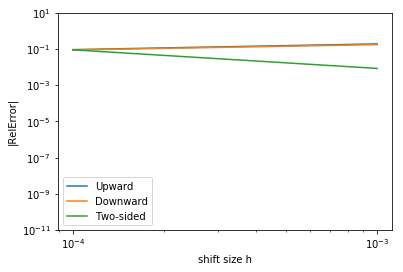

In [83]:
table1 = table.query('n_grid_points==51')
plotRelativeError(table1,'I')

### 6.2 (a) Simpson's method

In [254]:
%%capture
table_simpson = compute_integration2(SimpsonIntegration,n_grid_points=[51,101,201])

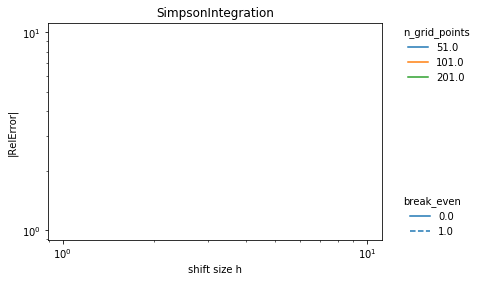

In [261]:
plotRelativeError2(table_simpson,'I',leg1='n_grid_points',leg2='break_even',title='SimpsonIntegration',integration_method='Two-sided')

In [217]:
%%capture
table, comp_time = compute_integration2_multiple(hs=[10**(-i) for i in [3,5]])

In [252]:
idx = table['density_integration_method'] == 'HermiteIntegration'
table.loc[idx,'density_integration_method'] = table.loc[idx]['density_integration_method'] + '_' + table.loc[idx]['degree'].astype(str)
table.head(10)

,h,n_grid_points,lambda_std_devs,break_even,Vega,B0,Bp,Bm,H0,Hp,Hm,I0,Ip,Im,density_integration_method,degree
0,0.00100,101.0,5.0,0.0,1.322286,23.626817,39.041941,12.550592,23.626817,39.041941,12.550592,23.499264,38.846813,12.435589,SimpsonIntegration,0
1,0.00100,101.0,5.0,1.0,1.322286,23.626817,39.041941,12.550592,23.626817,39.041941,12.550592,23.626889,39.023934,12.538882,SimpsonIntegration,0
2,0.00001,101.0,5.0,0.0,1.322286,23.626817,23.759264,23.494807,23.626817,23.759264,23.494807,23.499264,23.646164,23.352299,SimpsonIntegration,0
3,0.00001,101.0,5.0,1.0,1.322286,23.626817,23.759264,23.494807,23.626817,23.759264,23.494807,23.626889,23.759382,23.494832,SimpsonIntegration,0
0,0.00100,101.0,5.0,0.0,1.322286,23.626817,39.041941,12.550592,23.626817,39.041941,12.550592,23.581321,38.974721,12.497622,CubicSplineExactIntegration,0
1,0.00100,101.0,5.0,1.0,1.322286,23.626817,39.041941,12.550592,23.626817,39.041941,12.550592,23.625882,39.040917,12.549758,CubicSplineExactIntegration,0
2,0.00001,101.0,5.0,0.0,1.322286,23.626817,23.759264,23.494807,23.626817,23.759264,23.494807,23.581321,23.723727,23.438851,CubicSplineExactIntegration,0
3,0.00001,101.0,5.0,1.0,1.322286,23.626817,23.759264,23.494807,23.626817,23.759264,23.494807,23.625882,23.758328,23.493873,CubicSplineExactIntegration,0
0,0.00100,101.0,5.0,0.0,1.322286,23.626817,39.041941,12.550592,23.626817,39.041941,12.550592,8.027450,53.812891,0.284467,HermiteIntegration_3,3
1,0.00100,101.0,5.0,1.0,1.322286,23.626817,39.041941,12.550592,23.626817,39.041941,12.550592,-3099.471375,-3091.020487,-3101.998232,HermiteIntegration_3,3


Multiple integration methods were given, only one can be executed, default: Two-sided


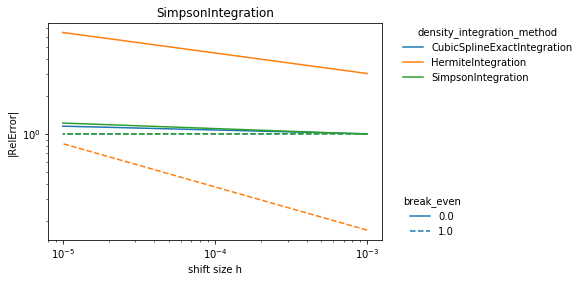

In [253]:
plotRelativeError2(d,'I',leg1='density_integration_method',leg2='break_even',title='SimpsonIntegration')

False